In [2]:
#Graph Neural Net to Identify Kenneth Lay as important person in Enron Dataset
from extractous import Extractor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time, csv
import regex as re
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric.utils import from_networkx
from sklearn.manifold import TSNE
from umap import UMAP
import networkx as nx
import scipy.stats as st
from dateutil import parser
import community as community_louvain 
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.utils import to_undirected, negative_sampling
from sklearn.decomposition import PCA
import plotly.express as px


os.chdir("C:\Data")
print(f"Current working drive: {os.getcwd()}")
root_dir = "C:\Data\maildir"


<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
C:\Users\graha\AppData\Local\Temp\ipykernel_22680\689102815.py:28: SyntaxWarning: invalid escape sequence '\D'
  os.chdir("C:\Data")
C:\Users\graha\AppData\Local\Temp\ipykernel_22680\689102815.py:30: SyntaxWarning: invalid escape sequence '\D'
  root_dir = "C:\Data\maildir"
c:\Users\graha\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working drive: C:\Data


In [3]:
#Importing data
valid_folders = {"inbox", "sent", "sent_items","_sent_mail"}
people = pd.read_csv(r"C:\Data\enron_hierarchy_people.csv")
people["folder_name"] = ( people["LastName"].str.lower() + "-" + people["FirstName"].str[0].str.lower())
valid_users = set(people["folder_name"])

emails = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    folder_name = os.path.basename(dirpath).lower()
    user_name = os.path.basename(os.path.dirname(dirpath)).lower()

    # Keep only valid user folders and mail folders
    if user_name in valid_users and folder_name in valid_folders:
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            try:
                if os.path.getsize(file_path) == 0:
                    continue
                with open(file_path, "r", encoding="latin1") as f:
                    content = f.read()
                    emails.append({
                        "user_folder": user_name,
                        "folder": folder_name,
                        "path": file_path,
                        "content": content
                    })
            except Exception as e:
                print(f"Skipping {file_path} due to {e}")

emails_df = pd.DataFrame(emails)

In [109]:
#Test People
valid_folders = {"inbox", "sent", "sent_items","_sent_mail"}
people_test = pd.read_csv(r"C:\Data\enron_new_combined_no_label.csv")
people_test["folder_name"] = (people_test["LastName"].str.lower() + "-" + people_test["FirstName"].str[0].str.lower())
valid_users_test = set(people_test["folder_name"])
print(valid_users_test)

emails_test = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    folder_name = os.path.basename(dirpath).lower()
    user_name = os.path.basename(os.path.dirname(dirpath)).lower()

    if user_name in valid_users_test and folder_name in valid_folders:
            for file in filenames:
                file_path = os.path.join(dirpath, file)
                try:
                    if os.path.getsize(file_path) == 0:
                        continue
                    with open(file_path, "r", encoding="latin1") as f:
                        content = f.read()
                        emails_test.append({
                            "user_folder": user_name,
                            "folder": folder_name,
                            "path": file_path,
                            "content": content
                        })
                except Exception as e:
                    print(f"Skipping {file_path} due to {e}")

emails_df_test = pd.DataFrame(emails_test)

print(emails_df_test)

{'buy-r', 'olson-c', 'st clair-c', 'kaminski-v', 'sager-e', 'kean-s', 'symes-k', 'glisan-b', 'shackleton-s', 'mann-k'}
      user_folder      folder                                         path  \
0           buy-r       inbox         C:\Data\maildir\buy-r\inbox\1031UQ~E   
1           buy-r       inbox         C:\Data\maildir\buy-r\inbox\103IQ1~1   
2           buy-r       inbox         C:\Data\maildir\buy-r\inbox\103XJO~P   
3           buy-r       inbox         C:\Data\maildir\buy-r\inbox\104706~A   
4           buy-r       inbox         C:\Data\maildir\buy-r\inbox\10D1GH~1   
...           ...         ...                                          ...   
32510     symes-k  _sent_mail  C:\Data\maildir\symes-k\_sent_mail\9A53U2~C   
32511     symes-k  _sent_mail  C:\Data\maildir\symes-k\_sent_mail\9AELGL~W   
32512     symes-k  _sent_mail  C:\Data\maildir\symes-k\_sent_mail\9AF3FP~F   
32513     symes-k  _sent_mail  C:\Data\maildir\symes-k\_sent_mail\9AOL2C~J   
32514     symes-k  _sen

In [4]:
#Preprocessing
#We have to count all the sents and received from each person, I'm thinking we simply start by looking at
#amount of sent and received form each person to draw a simple hierarchy structure.
#Eventually we can have it so we eventually find a central node that is treated as "transient"

#First we will pull the to, from, date, and subject of each email into a dataset

embedding_data = []

for i, row in emails_df.iterrows():
    #Get the text from the row
    text = row['content']
    to_from = row['folder']

    from_match = re.search(r"^From:\s*(.*)", text, re.MULTILINE)
    to_match   = re.search(r"^To:\s*(.*)", text, re.MULTILINE)
    subject_match = re.search(r"^Subject:\s*(.*)", text, re.MULTILINE)
    date_match = re.search(r"^Date:\s*(.*)", text, re.MULTILINE)
    

    from_addr = from_match.group(1).strip() if from_match else None
    to_addr   = to_match.group(1).strip() if to_match else None
    subject_addr = subject_match.group(1).strip() if subject_match else None
    date_addr = date_match.group(1).strip() if date_match else None
    #Append it to the dataset above
    embedding_data.append({
        "From": from_addr,
        "To": to_addr,
        "Date": date_addr,
        "Subject": subject_addr,
        "Type": to_from

    })

embedding_data = pd.DataFrame(embedding_data)


In [114]:
embedding_data_test = []

for i, row in emails_df_test.iterrows():
    #Get the text from the row
    text = row['content']
    to_from = row['folder']

    from_match = re.search(r"^From:\s*(.*)", text, re.MULTILINE)
    to_match   = re.search(r"^To:\s*(.*)", text, re.MULTILINE)
    subject_match = re.search(r"^Subject:\s*(.*)", text, re.MULTILINE)
    date_match = re.search(r"^Date:\s*(.*)", text, re.MULTILINE)
    

    from_addr = from_match.group(1).strip() if from_match else None
    to_addr   = to_match.group(1).strip() if to_match else None
    subject_addr = subject_match.group(1).strip() if subject_match else None
    date_addr = date_match.group(1).strip() if date_match else None
    #Append it to the dataset above
    embedding_data_test.append({
        "From": from_addr,
        "To": to_addr,
        "Date": date_addr,
        "Subject": subject_addr,
        "Type": to_from

    })

embedding_data_test = pd.DataFrame(embedding_data_test)

In [116]:
#Save it to csv so we don't have to read it in again
print("saving to csv")
embedding_data.to_csv("C:\Data\embedded_email_data.csv",index = False)
embedding_data_test.to_csv("C:\Data\embedded_email_data_test.csv",index = False)

saving to csv


<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\graha\AppData\Local\Temp\ipykernel_9680\1137731127.py:3: SyntaxWarning: invalid escape sequence '\D'
  embedding_data.to_csv("C:\Data\embedded_email_data.csv",index = False)
C:\Users\graha\AppData\Local\Temp\ipykernel_9680\1137731127.py:4: SyntaxWarning: invalid escape sequence '\D'
  embedding_data_test.to_csv("C:\Data\embedded_email_data_test.csv",index = False)


In [5]:
# Split multi-recipient "To" fields into lists
def split_recipients(to_field):
    if pd.isna(to_field):
        return []
    recipients = re.split(r'[;,]', str(to_field))
    return [r.strip() for r in recipients if r.strip() != ""]

# Create a new exploded DataFrame
embedding_data["To"] = embedding_data["To"].apply(split_recipients)
embedding_data = embedding_data.explode("To").reset_index(drop=True)

# Remove any empty rows (e.g., if 'To' was blank)
embedding_data = embedding_data[embedding_data["To"].notna() & (embedding_data["To"] != "")]

# Save the cleaned dataset
embedding_data.to_csv("embedded_email_data_expanded.csv", index=False)

In [135]:
# Create a new exploded DataFrame
embedding_data_test["To"] = embedding_data_test["To"].apply(split_recipients)
embedding_data_test = embedding_data_test.explode("To").reset_index(drop=True)

# Remove any empty rows (e.g., if 'To' was blank)
embedding_data_test = embedding_data_test[embedding_data_test["To"].notna() & (embedding_data_test["To"] != "")]

# Save the cleaned dataset
embedding_data_test.to_csv("embedded_email_data_expanded.csv", index=False)

In [6]:
#Here we will construct a markov chain to infer who is higher level, my idea here being
#people like ceo's should be transient as emails should make their way up the chain.

#Preprocessing to develop the markov chain
# Only keep From and To columns

#Here we are building edge feature: to_from probabilities in edges

to_from_count = embedding_data[["From", "To"]].dropna()
to_from_count["From"] = to_from_count["From"].str.lower().str.strip()
to_from_count["To"]   = to_from_count["To"].str.lower().str.strip()

# All unique email addresses appearing anywhere
people = sorted(set(to_from_count["From"]) | set(to_from_count["To"]))

# Initialize square matrix of zeros
P_raw = pd.DataFrame(0, index=people, columns=people, dtype=float)

# Count transitions
for _, row in to_from_count.iterrows():
    P_raw.loc[row["From"], row["To"]] += 1

P_raw.to_csv("P_raw.csv",index=False)

# Normalize rows to get transition probabilities
P = P_raw.div(P_raw.sum(axis=1), axis=0).fillna(0)

print(f"Built square transition matrix: {P.shape[0]}x{P.shape[1]}")

P.to_csv("P.csv",index=False)

Built square transition matrix: 6598x6598


In [137]:
to_from_count_test = embedding_data_test[["From", "To"]].dropna()
to_from_count_test["From"] = to_from_count_test["From"].str.lower().str.strip()
to_from_count_test["To"]   = to_from_count_test["To"].str.lower().str.strip()

# All unique email addresses appearing anywhere
people_test = sorted(set(to_from_count_test["From"]) | set(to_from_count_test["To"]))

# Initialize square matrix of zeros
P_raw_test = pd.DataFrame(0, index=people_test, columns=people_test, dtype=float)

# Count transitions
for _, row in to_from_count_test.iterrows():
    P_raw_test.loc[row["From"], row["To"]] += 1

P_raw_test.to_csv("P_raw.csv",index=False)

In [7]:
#use NetworkX to start building the graph structure, we will optimize later with GCN.

G_Enron = nx.from_pandas_adjacency(P_raw, create_using=nx.DiGraph)

#NX has built in functions to calculate core metrics like centrality of nodes
degree_centrality = nx.degree_centrality(G_Enron)
in_degree_centrality = nx.in_degree_centrality(G_Enron)
out_degree_centrality = nx.out_degree_centrality(G_Enron)

#Closeness Centrality
closeness_centrality = nx.closeness_centrality(G_Enron, distance='weight')

#Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G_Enron, weight='weight', normalized=True)

#PageRank
pagerank = nx.pagerank(G_Enron, weight='weight')

#Assign node embeddings
nx.set_node_attributes(G_Enron, degree_centrality, "degree_centrality")
nx.set_node_attributes(G_Enron, in_degree_centrality, "in_degree_centrality")
nx.set_node_attributes(G_Enron, out_degree_centrality, "out_degree_centrality")
nx.set_node_attributes(G_Enron, closeness_centrality, "closeness_centrality")
nx.set_node_attributes(G_Enron, betweenness_centrality, "betweenness_centrality")
nx.set_node_attributes(G_Enron, pagerank, "pagerank")



In [ ]:
G_Enron_test = nx.from_pandas_adjacency(P_raw_test, create_using=nx.DiGraph)

#NX has built in functions to calculate core metrics like centrality of nodes
degree_centrality_test = nx.degree_centrality(G_Enron_test)
in_degree_centrality_test = nx.in_degree_centrality(G_Enron_test)
out_degree_centrality_test = nx.out_degree_centrality(G_Enron_test)

#Closeness Centrality
closeness_centrality_test = nx.closeness_centrality(G_Enron_test, distance='weight')

#Betweenness Centrality
betweenness_centrality_test = nx.betweenness_centrality(G_Enron_test, weight='weight', normalized=True)

#PageRank
pagerank_test = nx.pagerank(G_Enron_test, weight='weight')

#Assign node embeddings
nx.set_node_attributes(G_Enron_test, degree_centrality_test, "degree_centrality")
nx.set_node_attributes(G_Enron_test, in_degree_centrality_test, "in_degree_centrality")
nx.set_node_attributes(G_Enron_test, out_degree_centrality_test, "out_degree_centrality")
nx.set_node_attributes(G_Enron_test, closeness_centrality_test, "closeness_centrality")
nx.set_node_attributes(G_Enron_test, betweenness_centrality_test, "betweenness_centrality")
nx.set_node_attributes(G_Enron_test, pagerank_test, "pagerank")

c:\Users\graha\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


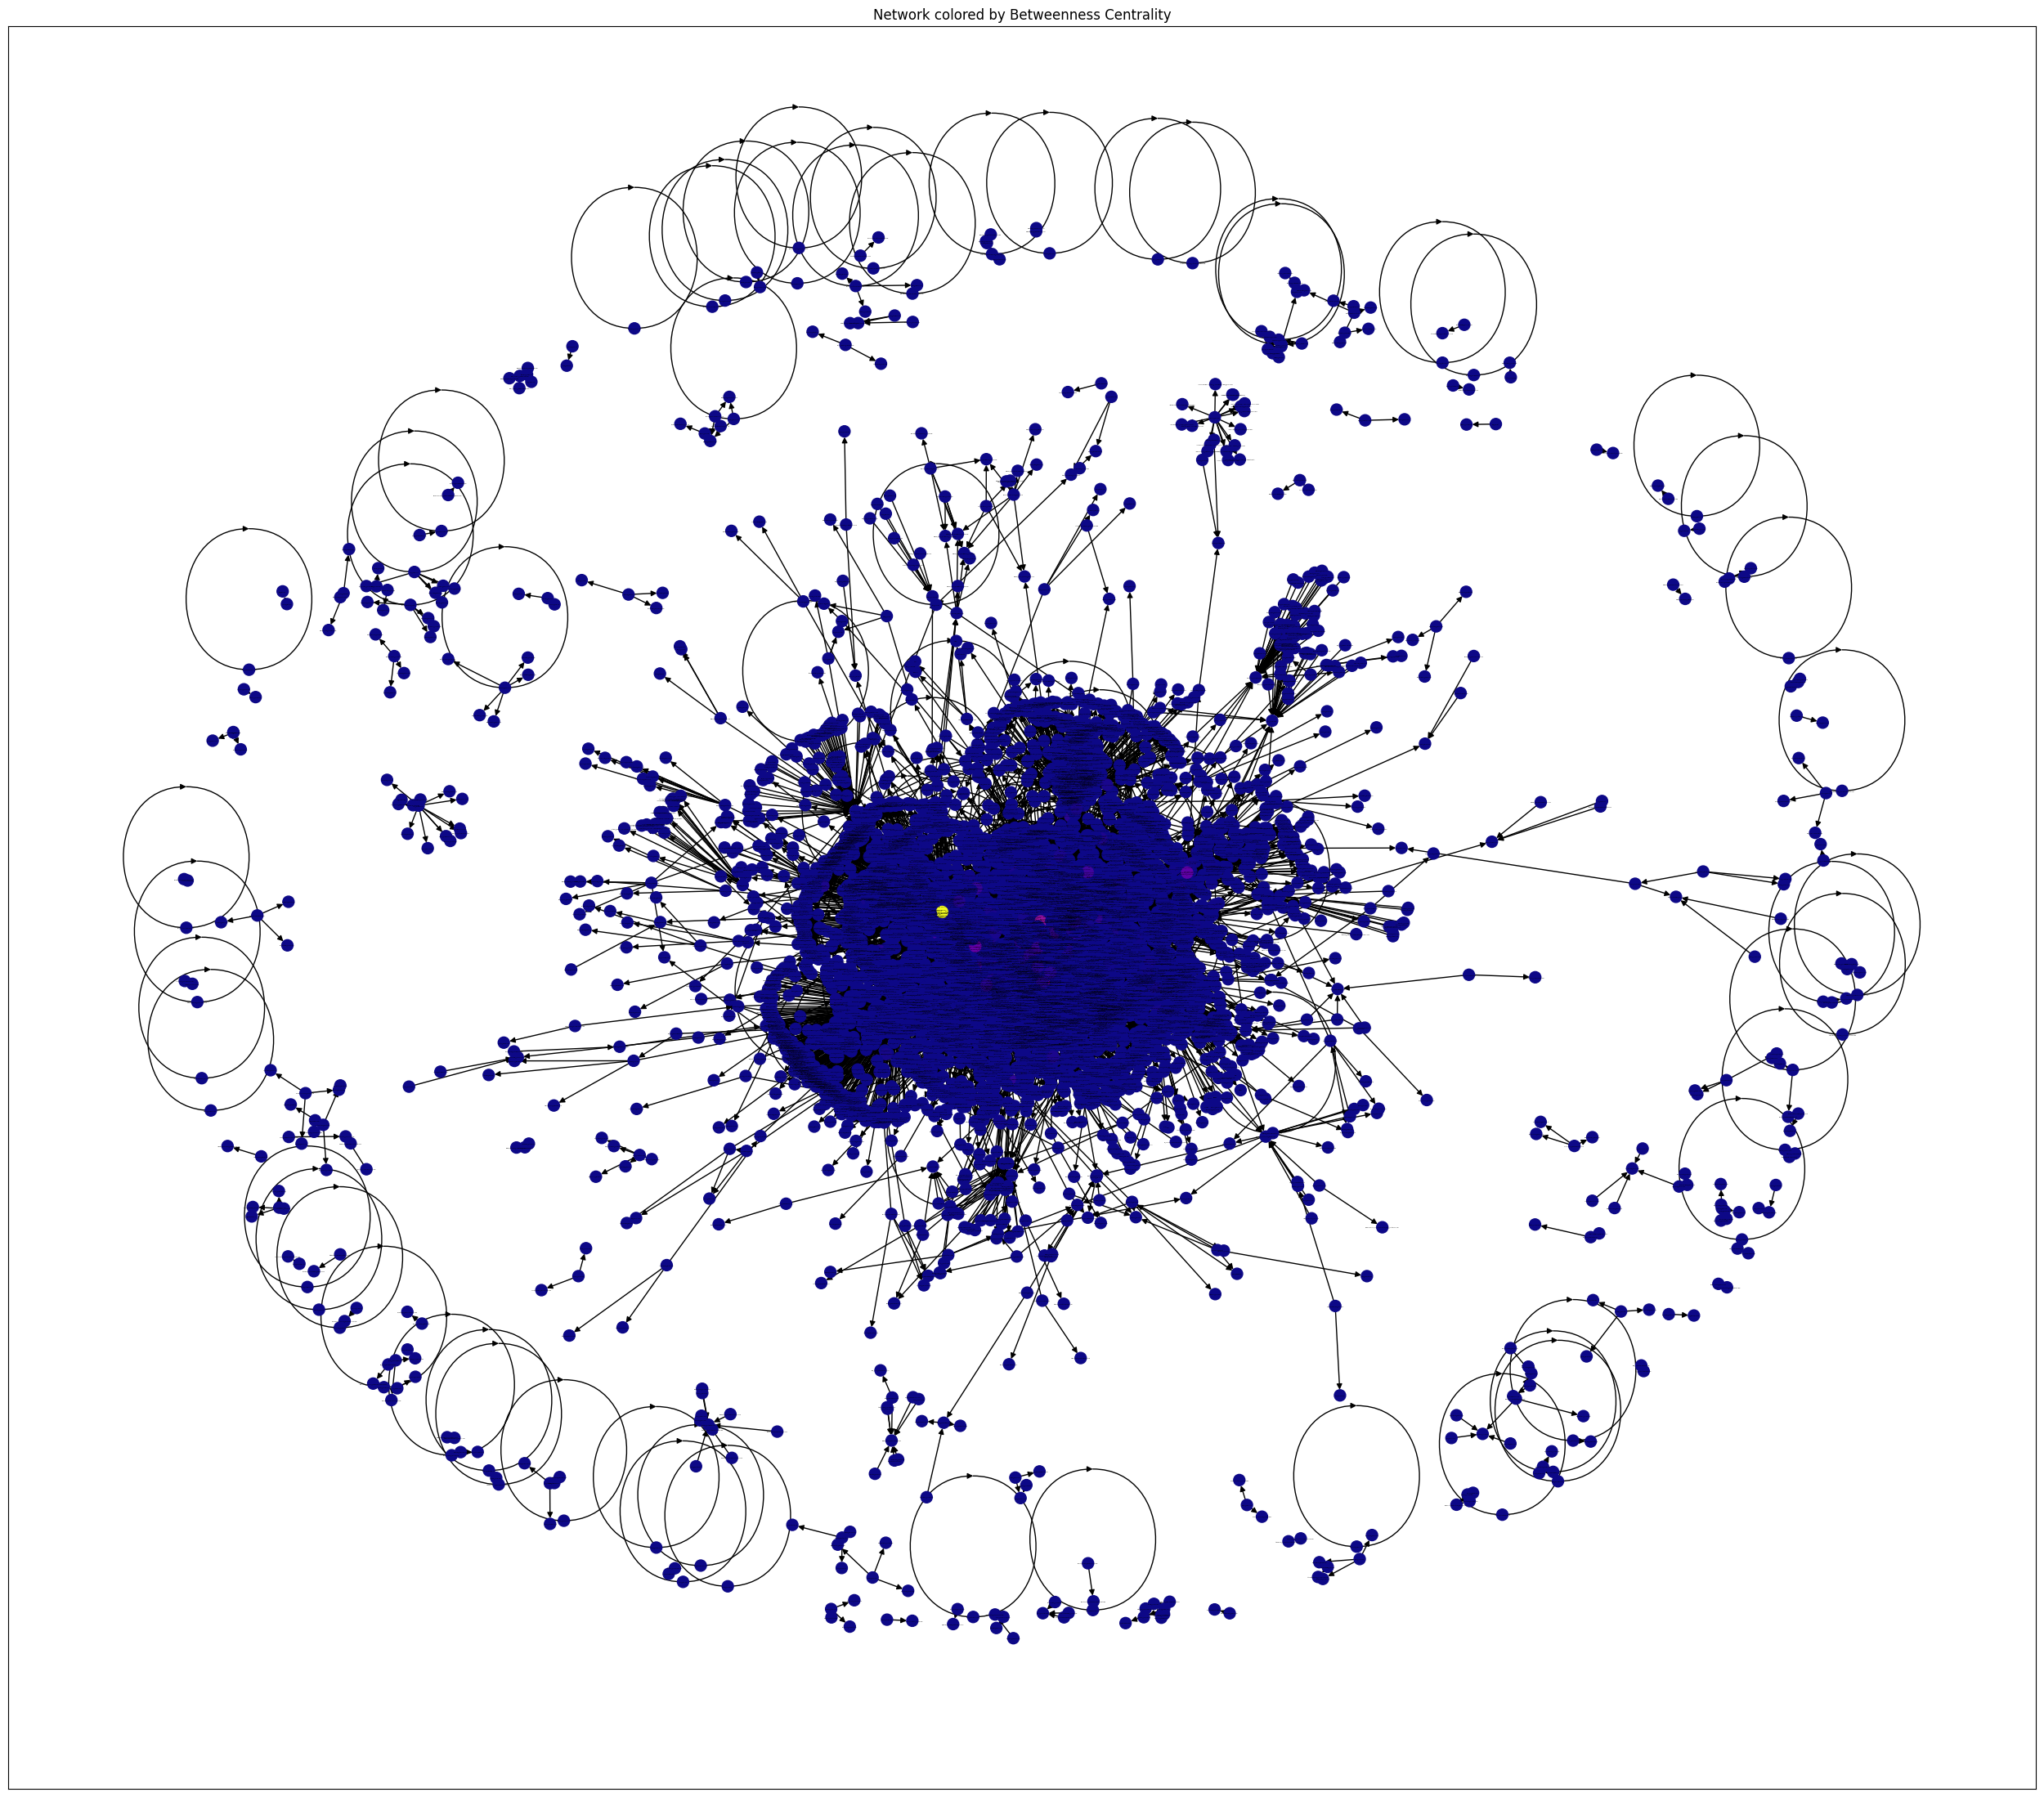

In [45]:
#Visualize the above

pos = nx.spring_layout(G_Enron, seed=1234,k=0.8,iterations=200)
node_color = [betweenness_centrality[n] for n in G_Enron.nodes()]

plt.figure(figsize=(32,28))
nx.draw_networkx(G_Enron, pos, with_labels=True, node_color=node_color, 
                 cmap=plt.cm.plasma, edge_color='black', node_size=100,font_size=1)
plt.title("Network colored by Betweenness Centrality")
plt.show()

Found 20 / 20 in the graph.


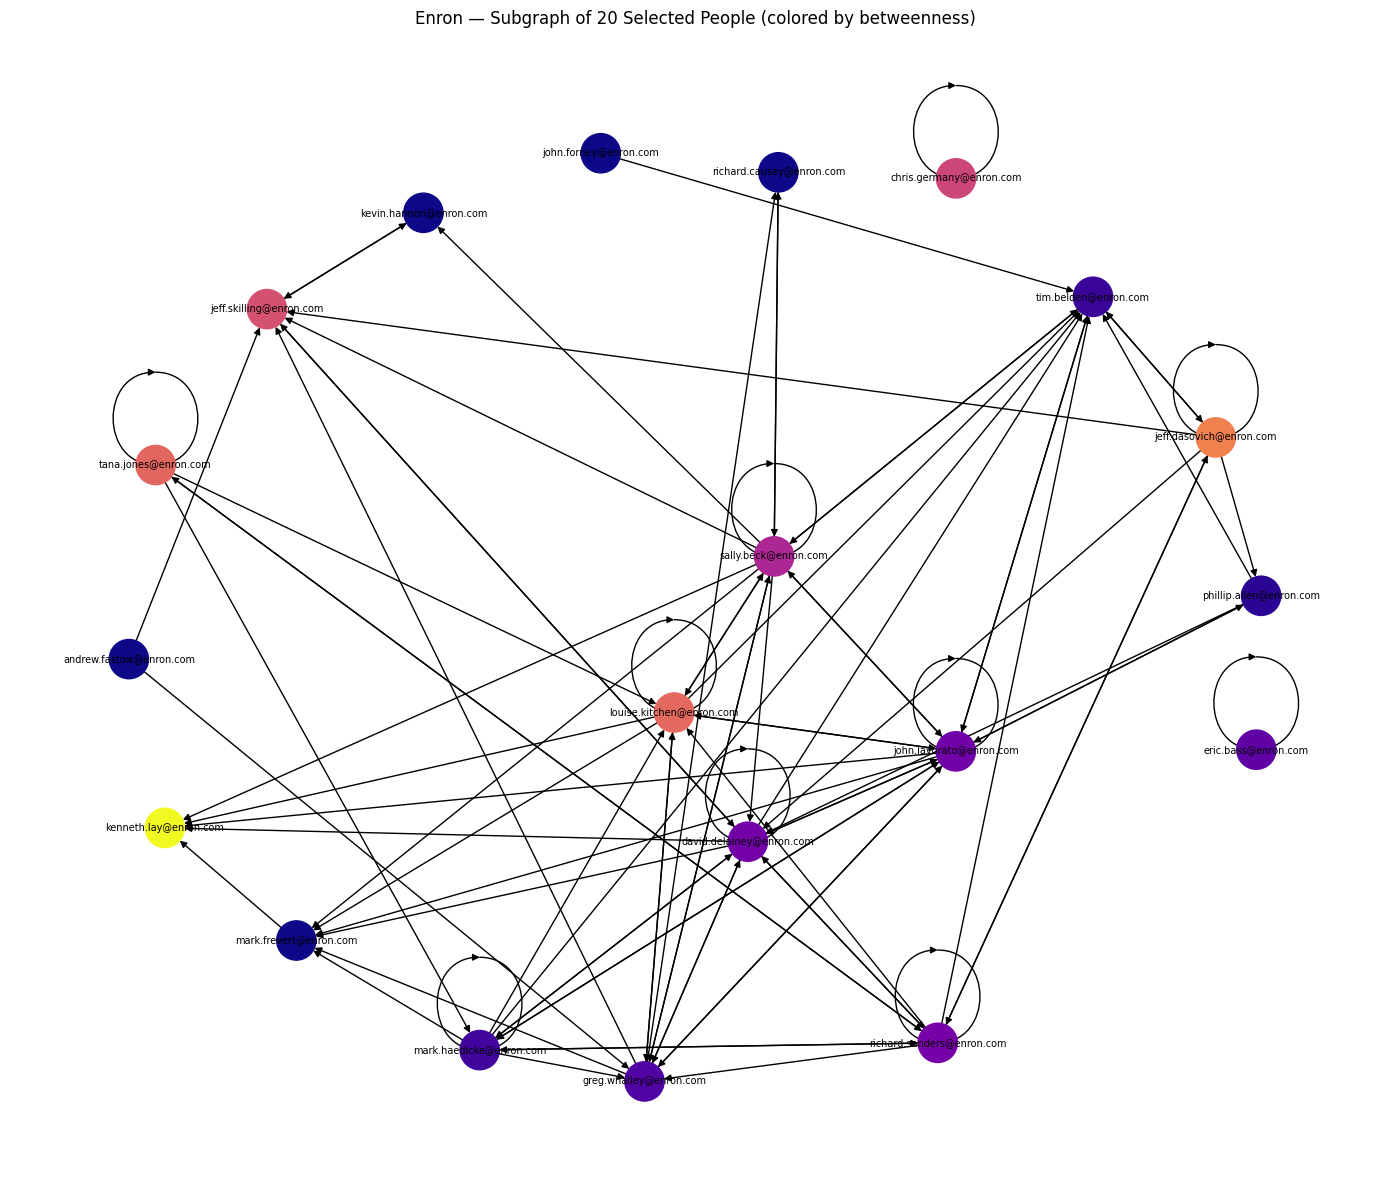

In [ ]:

orig20 = [
    "kenneth.lay@enron.com","jeff.skilling@enron.com","andrew.fastow@enron.com",
    "mark.frevert@enron.com","richard.causey@enron.com","louise.kitchen@enron.com",
    "john.lavorato@enron.com","david.delainey@enron.com","greg.whalley@enron.com",
    "mark.haedicke@enron.com","richard.sanders@enron.com","sally.beck@enron.com",
    "kevin.hannon@enron.com","tim.belden@enron.com","john.forney@enron.com",
    "jeff.dasovich@enron.com","tana.jones@enron.com","phillip.allen@enron.com",
    "chris.germany@enron.com","eric.bass@enron.com",
]

# Map graph nodes case-insensitively to their actual labels
lower_to_node = {str(n).lower(): n for n in G_Enron.nodes()}
present = [lower_to_node[e] for e in orig20 if e in lower_to_node]
missing = [e for e in orig20 if e not in lower_to_node]
print(f"Found {len(present)} / 20 in the graph.")
if missing:
    print("Missing:", missing)

# Induced subgraph on just those nodes
G20 = G_Enron.subgraph(present).copy()

# Use betweenness you already computed, else compute for subgraph
try:
    node_color = [betweenness_centrality.get(n, 0.0) for n in G20.nodes()]
except NameError:
    bc_sub = nx.betweenness_centrality(G20, normalized=True, weight="weight")
    node_color = [bc_sub[n] for n in G20.nodes()]

# Reuse positions if you already computed `pos`; otherwise make a fresh layout
try:
    pos_init = {n: pos[n] for n in G20.nodes() if n in pos}  # seed with global layout

    pos20 = nx.spring_layout(
        G20,
        k=5,
        iterations=200,
        seed=1234,
        pos=pos_init,   # initialize near previous positions
        fixed=None )     # or list of nodes to keep fixed
except NameError:
    pos20 = nx.spring_layout(G20, seed=1234, k=5, iterations=200)

plt.figure(figsize=(14,12))
nx.draw_networkx(
    G20, pos20,
    with_labels=True,
    labels={n: n for n in G20.nodes()},  # email labels
    node_color=node_color,
    cmap=plt.cm.plasma,
    edge_color='black',
    node_size=800,
    font_size=7
)
plt.title("Enron — Subgraph of 20 Selected People (colored by betweenness)")
plt.axis('off')
plt.tight_layout()
plt.show()


# Below is the code for the Graph Autoencoder

In [9]:
# 1) Fix a stable node order
nodes = list(G_Enron.nodes())
node_index = {n:i for i,n in enumerate(nodes)}

# 2) Build feature matrix from your attributes
feat_keys = [
    "degree_centrality",
    "in_degree_centrality",
    "out_degree_centrality",
    "closeness_centrality",
    "betweenness_centrality",
    "pagerank",
]

X_np = np.stack([np.array([G_Enron.nodes[n].get(k, 0.0) for n in nodes], dtype=float) for k in feat_keys], axis=1)  # shape [n_nodes, n_feats]

# 3) Normalize features for stability
X_np = MinMaxScaler().fit_transform(X_np)

# 4) Build a composite centrality score (already normalized to [0,1])
c_np = X_np.mean(axis=1, keepdims=True)  # simple average over the 6 centrality features

X = torch.tensor(X_np, dtype=torch.float)            # [N, F]
c = torch.tensor(c_np, dtype=torch.float).view(-1)   # [N]

In [10]:
# Ensure 'weight' exists on edges; if it doesn’t, default to 1.0
for u, v in G_Enron.edges():
    if 'weight' not in G_Enron[u][v]:
        G_Enron[u][v]['weight'] = 1.0

# Move node features into the NX graph so from_networkx can grab them if desired
for i, n in enumerate(nodes):
    G_Enron.nodes[n]['x'] = X_np[i]

# Convert to PyG data
data = from_networkx(G_Enron)
# data.x may be None depending on PyG version; we’ll overwrite to be safe
data.x = X
data.num_nodes = X.size(0)

# For an inner-product decoder, undirected edges work best:
data.edge_index = to_undirected(data.edge_index, num_nodes=data.num_nodes)


c:\Users\graha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  data_dict[key] = torch.as_tensor(value)


In [11]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        return z  # [N, d]

class InnerProductDecoder(nn.Module):
    def forward(self, z, edge_index):
        # Score only the pairs in edge_index (2,E)
        # score = <z_i, z_j>
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        return (z_i * z_j).sum(dim=1)  # logits (no sigmoid)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = data.x.to(device)
edge_index = data.edge_index.to(device)
N = data.num_nodes

encoder = GCNEncoder(in_dim=X.size(1), hidden_dim=64, latent_dim=32).to(device)
decoder = InnerProductDecoder().to(device)
opt = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=5e-5)

# Build positive edges (undirected, but keep unique i<j)
# torch_geometric.utils.negative_sampling expects coalesced edges
pos_edge_index = edge_index  # already undirected/coalesced from Step 2


In [13]:
c = c.to(device)  # [N]

bce = nn.BCEWithLogitsLoss()

def reconstruction_loss(z, pos_ei, num_neg=None):
    if num_neg is None:
        num_neg = pos_ei.size(1)
    # Negative sample non-edges
    neg_ei = negative_sampling(
        pos_ei, num_nodes=z.size(0), num_neg_samples=num_neg, method='sparse'
    ).to(z.device)

    # Scores
    pos_logits = decoder(z, pos_ei)        # [E_pos]
    neg_logits = decoder(z, neg_ei)        # [E_neg]

    # Labels
    y_pos = torch.ones_like(pos_logits)
    y_neg = torch.zeros_like(neg_logits)

    # BCE
    loss_pos = bce(pos_logits, y_pos)
    loss_neg = bce(neg_logits, y_neg)
    return loss_pos + loss_neg

def centrality_loss(z, c, k=1024, alpha_pull=1.0, beta_push=1.0):
    """
    Randomly sample pairs to keep it O(k) per step.
    - Pull: high-high pairs should be similar (large dot product)
    - Push: pairs with very different centrality should have low similarity
    """
    N = z.size(0)
    if N <= 1:
        return z.new_tensor(0.0)

    # Sample k pairs (with replacement)
    i = torch.randint(0, N, (k,), device=z.device)
    j = torch.randint(0, N, (k,), device=z.device)
    same = i != j
    i, j = i[same], j[same]
    if i.numel() == 0:
        return z.new_tensor(0.0)

    zi, zj = z[i], z[j]
    sim_ij = F.cosine_similarity(zi, zj)  # [-1, 1]
    ci, cj = c[i], c[j]

    # Pull term: encourage similarity for high-high pairs
    high_mask = (ci > 0.8) & (cj > 0.8)  # threshold can be tuned
    pull = 0.0
    if high_mask.any():
        # We want sim close to 1 → minimize (1 - sim)
        pull = (1.0 - sim_ij[high_mask]).mean()

    # Push term: penalize similarity when centrality differs
    # weight by |ci - cj|
    diff = (ci - cj).abs()
    push = (diff * torch.clamp(sim_ij, min=0.0)).mean()  # only penalize positive similarity

    return alpha_pull * pull + beta_push * push


In [14]:
lambda_cent = 0.5     # strength of centrality shaping
epochs = 200

for epoch in range(1, epochs+1):
    encoder.train()
    opt.zero_grad()

    z = encoder(X, edge_index)  # [N, d]

    loss_rec = reconstruction_loss(z, pos_edge_index, num_neg=None)
    loss_cent = centrality_loss(z, c, k=min(4096, X.size(0)*8),
                                alpha_pull=1.0, beta_push=1.0)

    loss = loss_rec + lambda_cent * loss_cent
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Rec: {loss_rec.item():.4f} | Cent: {loss_cent.item():.4f} | Total: {loss.item():.4f}")


Epoch 001 | Rec: 1.2005 | Cent: 0.0407 | Total: 1.2209
Epoch 020 | Rec: 1.0443 | Cent: 0.0455 | Total: 1.0670
Epoch 040 | Rec: 1.0273 | Cent: 0.0418 | Total: 1.0482
Epoch 060 | Rec: 1.0095 | Cent: 0.0321 | Total: 1.0255
Epoch 080 | Rec: 0.9811 | Cent: 0.0217 | Total: 0.9919
Epoch 100 | Rec: 0.9549 | Cent: 0.0174 | Total: 0.9636
Epoch 120 | Rec: 0.9382 | Cent: 0.0143 | Total: 0.9453
Epoch 140 | Rec: 0.9224 | Cent: 0.0132 | Total: 0.9290
Epoch 160 | Rec: 0.9207 | Cent: 0.0128 | Total: 0.9271
Epoch 180 | Rec: 0.9174 | Cent: 0.0123 | Total: 0.9236
Epoch 200 | Rec: 0.9128 | Cent: 0.0126 | Total: 0.9191


In [15]:
encoder.eval()
with torch.no_grad():
    Z = encoder(X, edge_index)  # [N, d]

# Example: average cosine similarity among the top 10% central vs bottom 10%
c_np = c.detach().cpu().numpy().reshape(-1)
th_hi = np.quantile(c_np, 0.9)
th_lo = np.quantile(c_np, 0.1)
hi_idx = torch.tensor(np.where(c_np >= th_hi)[0], device=Z.device)
lo_idx = torch.tensor(np.where(c_np <= th_lo)[0], device=Z.device)

def avg_cosine(sim_group):
    g = Z[sim_group]
    g = F.normalize(g, dim=1)
    s = torch.mm(g, g.t())
    # exclude diagonal
    mask = ~torch.eye(s.size(0), dtype=torch.bool, device=s.device)
    return s[mask].mean().item() if s.numel() > 1 else float('nan')

avg_hi = avg_cosine(hi_idx)
avg_lo = avg_cosine(lo_idx)
print(f"Avg cosine among TOP 10% central:   {avg_hi:.3f}")
print(f"Avg cosine among BOTTOM 10% central:{avg_lo:.3f}")


Avg cosine among TOP 10% central:   0.960
Avg cosine among BOTTOM 10% central:0.957


# Display Results of Autoencoder

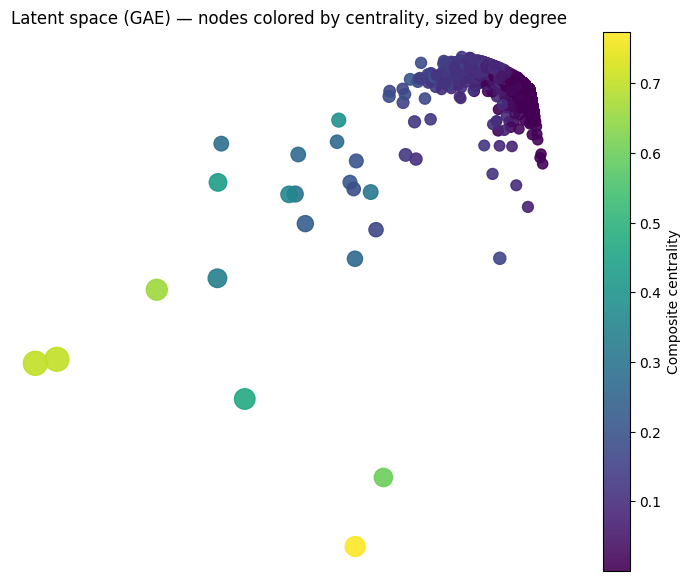

In [17]:
# ---- prepare 2D coordinates from embeddings Z ----
Z_np = Z.detach().cpu().numpy()
if Z_np.shape[1] >= 2:
    coords = PCA(n_components=2).fit_transform(Z_np)
else:
    coords = np.hstack([Z_np, np.zeros((Z_np.shape[0], 1))])

# centrality (0..1) and degree for sizing
c_np = c.detach().cpu().numpy()

deg = np.array([G_Enron.degree(n) for n in nodes], dtype=float)

# Safe min-max normalize degrees to [0,1] (works even if all equal)
rng = np.ptp(deg)  # NumPy 2.0-compatible
if rng == 0:
    deg_norm = np.zeros_like(deg)  # all same size if graph is regular
else:
    deg_norm = (deg - deg.min()) / rng

sizes = 50 + 250 * deg_norm  # point sizes

plt.figure(figsize=(9,7))
sc = plt.scatter(coords[:,0], coords[:,1],
                 c=c_np.flatten(), s=sizes, alpha=0.9)
plt.colorbar(sc, label="Composite centrality")
plt.title("Latent space (GAE) — nodes colored by centrality, sized by degree")
plt.axis('off')
plt.show()

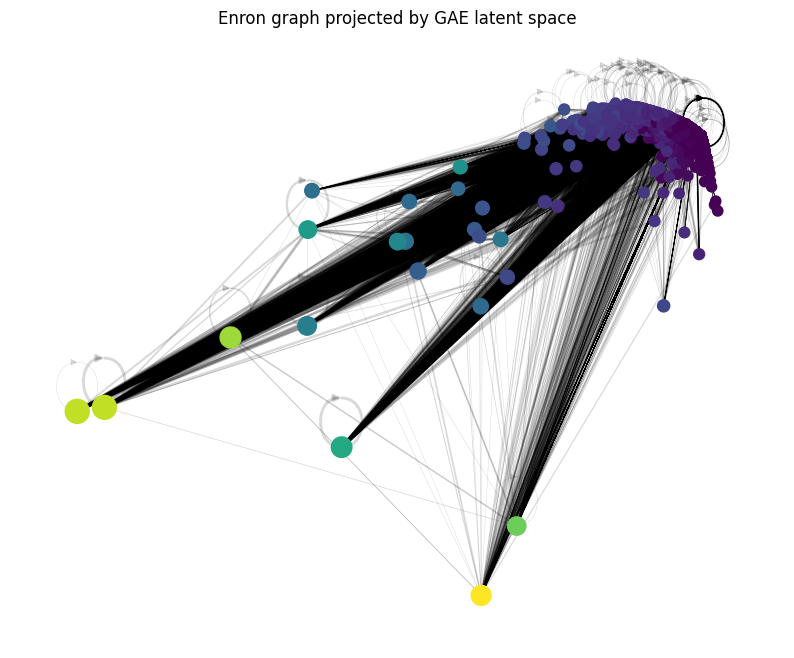

In [19]:
# assumes: coords, nodes, c_np, G_Enron defined from Step A
pos = {n: (coords[i, 0], coords[i, 1]) for i, n in enumerate(nodes)}

# Optional: scale edge widths by weight if present (fallback = 1.0)
edge_widths = []
for u, v, d in G_Enron.edges(data=True):
    w = d.get("weight", 1.0)
    edge_widths.append(np.log1p(w) * 0.5)  # tweak multiplier if too thick/thin

plt.figure(figsize=(10, 8))

# Light edges first (use alpha for readability)
nx.draw_networkx_edges(
    G_Enron,
    pos,
    alpha=0.15,
    width=edge_widths if len(edge_widths) == G_Enron.number_of_edges() else 0.5,
    arrows=False  # set True if you want arrowheads and your graph is directed
)

# Node colors (centrality) and sizes (degree) reused from Step A
node_color = c_np.flatten()

nx.draw_networkx_nodes(
    G_Enron, pos,
    node_color=node_color,
    node_size=sizes,
    cmap="viridis"
)

plt.title("Enron graph projected by GAE latent space")
plt.axis("off")
plt.show()

In [23]:
# Helper to pull attributes safely
def grab_attr(key):
    return [G_Enron.nodes[n].get(key, 0.0) for n in nodes]

df = pd.DataFrame({
    "node": nodes,
    "x": coords[:, 0],
    "y": coords[:, 1],
    "centrality": c_np.flatten(),
    "degree": [G_Enron.degree(n) for n in nodes],
    "in_deg": grab_attr("in_degree_centrality"),
    "out_deg": grab_attr("out_degree_centrality"),
    "close": grab_attr("closeness_centrality"),
    "betw": grab_attr("betweenness_centrality"),
    "pagerank": grab_attr("pagerank"),
})

fig = px.scatter(
    df, x="x", y="y",
    color="centrality",
    size="degree",
    hover_data=["node", "in_deg", "out_deg", "close", "betw", "pagerank"],
    title="GAE latent space (interactive)"
)
fig.update_traces(marker=dict(line=dict(width=0)))
fig.update_layout(xaxis_visible=False, yaxis_visible=False)
fig.show()

# Plotly (from step C): save interactive HTML
fig.write_html("enron_gae_latent.html", include_plotlyjs="cdn")

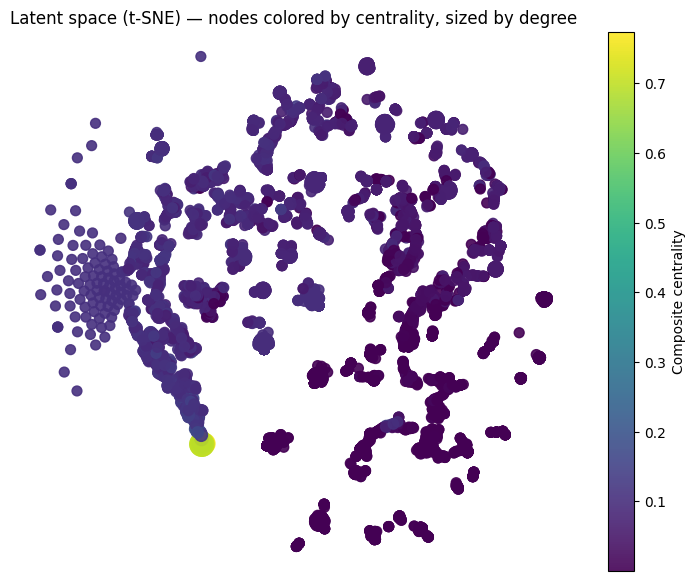

In [22]:
Z_np = Z.detach().cpu().numpy()

# t-SNE (good for small–medium N; can be slow for very large graphs)
coords_tsne = TSNE(
    n_components=2, learning_rate="auto", init="pca", perplexity=30, random_state=42
).fit_transform(Z_np)

# (alternative)
# coords_umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(Z_np)

# Quick plot preview for t-SNE
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 7))
sc = plt.scatter(coords_tsne[:, 0], coords_tsne[:, 1],
                 c=c_np.flatten(), s=sizes, alpha=0.9)
plt.colorbar(sc, label="Composite centrality")
plt.title("Latent space (t-SNE) — nodes colored by centrality, sized by degree")
plt.axis("off")
plt.show()

# Below is the Code for the Temporal GCN

In [46]:
#Some basic EDA

# Top 10 by PageRank
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Nodes by PageRank:")
for node, score in top_pagerank:
    print(f"{node:30}  {score:.4f}")

Top 10 Nodes by PageRank:
kenneth.lay@enron.com           0.0385
jeff.skilling@enron.com         0.0268
sally.beck@enron.com            0.0162
jeff.dasovich@enron.com         0.0118
greg.whalley@enron.com          0.0096
e..haedicke@enron.com           0.0091
tana.jones@enron.com            0.0084
john.lavorato@enron.com         0.0084
chris.germany@enron.com         0.0066
louise.kitchen@enron.com        0.0063


In [47]:
#EDA

# Combine metrics into a DataFrame
centrality_df = pd.DataFrame({
    'PageRank': pagerank,
    'Betweenness': betweenness_centrality,
    'Closeness': closeness_centrality
})

# Sort by a specific metric
top_nodes = centrality_df.sort_values(by='PageRank', ascending=False).head(10)
print(top_nodes)

                          PageRank  Betweenness  Closeness
kenneth.lay@enron.com     0.038550     0.047592   0.097660
jeff.skilling@enron.com   0.026783     0.035407   0.085586
sally.beck@enron.com      0.016218     0.045646   0.091828
jeff.dasovich@enron.com   0.011846     0.042486   0.074032
greg.whalley@enron.com    0.009632     0.011435   0.073694
e..haedicke@enron.com     0.009143     0.036106   0.086653
tana.jones@enron.com      0.008401     0.048304   0.070659
john.lavorato@enron.com   0.008394     0.014019   0.079305
chris.germany@enron.com   0.006629     0.026974   0.054465
louise.kitchen@enron.com  0.006333     0.025396   0.084558


In [ ]:
#Now incorporating time with a Temporal GCN, but first need to build in the time into the intervals of values

embedding_data_time = embedding_data

#Having issues with the (PTC) brackets so removing them
def clean_email_date(d):
    if pd.isna(d): 
        return pd.NaT
    d = str(d).replace('  ', ' ').strip()          # remove double spaces
    d = d.split('(')[0].strip()                    # remove (PDT) or any (...) text
    try:
        return parser.parse(d, fuzzy=True)         # dateutil handles most cases
    except Exception:
        return pd.NaT

embedding_data_time["Date_clean"] = embedding_data_time["Date"].apply(clean_email_date)

embedding_data_time["Date_clean"] = pd.to_datetime(embedding_data_time["Date_clean"], errors="coerce", utc=True)

#Seperate it into months
embedding_data_time["Month"] = embedding_data_time["Date_clean"].dt.to_period("M")


0         Tue, 1 Jan 2002 14:46:05 -0800 (PST)
1         Tue, 1 Jan 2002 17:19:40 -0800 (PST)
2        Mon, 31 Dec 2001 02:24:51 -0800 (PST)
3        Mon, 31 Dec 2001 10:53:43 -0800 (PST)
4        Mon, 31 Dec 2001 10:53:43 -0800 (PST)
                         ...                  
55071     Fri, 8 Jun 2001 06:58:00 -0700 (PDT)
55072     Fri, 8 Jun 2001 06:58:00 -0700 (PDT)
55073     Fri, 8 Jun 2001 06:58:00 -0700 (PDT)
55074     Thu, 7 Jun 2001 05:34:00 -0700 (PDT)
55075     Wed, 6 Jun 2001 14:53:00 -0700 (PDT)
Name: Date, Length: 54211, dtype: object


C:\Users\graha\AppData\Local\Temp\ipykernel_9680\3223179927.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  embedding_data_time["Month"] = embedding_data_time["Date_clean"].dt.to_period("M")


In [145]:
embedding_data_time_test = embedding_data_test

embedding_data_time_test["Date_clean"] = embedding_data_time_test["Date"].apply(clean_email_date)

embedding_data_time_test["Date_clean"] = pd.to_datetime(embedding_data_time_test["Date_clean"], errors="coerce", utc=True)

#Seperate it into months
embedding_data_time_test["Month"] = embedding_data_time_test["Date_clean"].dt.to_period("M")

C:\Users\graha\AppData\Local\Temp\ipykernel_9680\102812603.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  embedding_data_time_test["Month"] = embedding_data_time_test["Date_clean"].dt.to_period("M")


In [ ]:
# --- STEP 1: Filter internal Enron-only emails ---
mask = (
    embedding_data_time["From"].str.contains("@enron.com", na=False)
    & embedding_data_time["To"].str.contains("@enron.com", na=False)
)
internal_df = embedding_data_time[mask].copy()

print(f"Internal-only emails retained: {len(internal_df)} / {len(embedding_data_time)}")

# --- STEP 2: Build one square adjacency + NetworkX graph per month ---
graphs_by_time = {}
nx_graphs = {}

for month, df_month in internal_df.groupby("Month"):

    # Define all unique nodes for this month
    senders = df_month["From"].unique()
    receivers = df_month["To"].unique()
    nodes = sorted(set(senders) | set(receivers))

    # Build adjacency matrix (# of emails sent From → To)
    P_t = pd.crosstab(df_month["From"], df_month["To"])
    P_t = P_t.reindex(index=nodes, columns=nodes, fill_value=0)

    # Store both adjacency and networkx graph
    graphs_by_time[month] = P_t
    nx_graphs[month] = nx.from_pandas_adjacency(P_t, create_using=nx.DiGraph)

# --- STEP 3: Filter graphs with enough structure (avoid sparse ones) ---
nx_graphs = {m: G for m, G in nx_graphs.items() if len(G.nodes()) > 10 and len(G.edges()) > 10}
print(f"Graphs retained after filtering: {len(nx_graphs)} months")

# --- STEP 4: Compute In and Out Degree (Not sure if I will just include these two or more in final draft) for each remaining month ---
#adding in other metrics for the monthly basis
metrics = []
for month, G_t in nx_graphs.items():
    in_deg = nx.in_degree_centrality(G_t)
    out_deg = nx.out_degree_centrality(G_t)
    deg_centrality = nx.degree_centrality(G_t)
    clo_centrality = nx.closeness_centrality(G_t)
    bet_centrality = nx.betweenness_centrality(G_t)


    for node in G_t.nodes():
        metrics.append({
            "Month": month,
            "Node": node,
            "InDegree": in_deg.get(node, 0),
            "OutDegree": out_deg.get(node, 0),
            "Degree_Centrality": deg_centrality.get(node,0),
            "Closeness_Centrality": clo_centrality.get(node,0),
            "betweenness_Centrality": bet_centrality.get(node,0),
        })

metrics_df = pd.DataFrame(metrics)

# Convert Month column to datetime if needed
if pd.api.types.is_period_dtype(metrics_df["Month"]):
    metrics_df["Month"] = metrics_df["Month"].dt.to_timestamp()
elif metrics_df["Month"].dtype == object:
    metrics_df["Month"] = pd.to_datetime(metrics_df["Month"], errors="coerce")

# Drop invalid rows and sort
metrics_df = metrics_df.dropna(subset=["Month"])
metrics_df = metrics_df.sort_values("Month")


Internal-only emails retained: 41863 / 54211
Graphs retained after filtering: 38 months


C:\Users\graha\AppData\Local\Temp\ipykernel_9680\3421925140.py:64: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(metrics_df["Month"]):


In [ ]:
# --- STEP 1: Filter internal Enron-only emails ---
mask_test = (
    embedding_data_time_test["From"].str.contains("@enron.com", na=False)
    & embedding_data_time_test["To"].str.contains("@enron.com", na=False)
)
internal_df_test = embedding_data_time_test[mask_test].copy()

print(f"Internal-only emails retained: {len(internal_df_test)} / {len(embedding_data_time_test)}")

# --- STEP 2: Build one square adjacency + NetworkX graph per month ---
graphs_by_time_test = {}
nx_graphs_test = {}

for month, df_month in internal_df_test.groupby("Month"):

    # Define all unique nodes for this month
    senders = df_month["From"].unique()
    receivers = df_month["To"].unique()
    nodes = sorted(set(senders) | set(receivers))

    # Build adjacency matrix (# of emails sent From → To)
    P_t = pd.crosstab(df_month["From"], df_month["To"])
    P_t = P_t.reindex(index=nodes, columns=nodes, fill_value=0)

    # Store both adjacency and networkx graph
    graphs_by_time_test[month] = P_t
    nx_graphs_test[month] = nx.from_pandas_adjacency(P_t, create_using=nx.DiGraph)

# --- STEP 3: Filter graphs with enough structure (avoid sparse ones) ---
nx_graphs_test = {m: G for m, G in nx_graphs_test.items() if len(G.nodes()) > 10 and len(G.edges()) > 10}
print(f"Graphs retained after filtering: {len(nx_graphs_test)} months")

# --- STEP 4: Compute In and Out Degree (Not sure if I will just include these two or more in final draft) for each remaining month ---
#adding in other metrics for the monthly basis
metrics_test = []
for month, G_t in nx_graphs_test.items():
    in_deg = nx.in_degree_centrality(G_t)
    out_deg = nx.out_degree_centrality(G_t)
    deg_centrality = nx.degree_centrality(G_t)
    clo_centrality = nx.closeness_centrality(G_t)
    bet_centrality = nx.betweenness_centrality(G_t)

    for node in G_t.nodes():
        metrics_test.append({
            "Month": month,
            "Node": node,
            "InDegree": in_deg.get(node, 0),
            "OutDegree": out_deg.get(node, 0),
            "Degree_Centrality": deg_centrality.get(node,0),
            "Closeness_Centrality": clo_centrality.get(node,0),
            "betweenness_Centrality": bet_centrality.get(node,0),
            # "Community": partition.get(node, -1),
            # "Modularity": mod_score
        })

metrics_df_test = pd.DataFrame(metrics_test)


# Convert Month column to datetime if needed
if pd.api.types.is_period_dtype(metrics_df_test["Month"]):
    metrics_df_test["Month"] = metrics_df_test["Month"].dt.to_timestamp()
elif metrics_df_test["Month"].dtype == object:
    metrics_df_test["Month"] = pd.to_datetime(metrics_df_test["Month"], errors="coerce")

# Drop invalid rows and sort
metrics_df_test = metrics_df_test.dropna(subset=["Month"])
metrics_df_test = metrics_df_test.sort_values("Month")

Internal-only emails retained: 28656 / 39285
Graphs retained after filtering: 35 months


C:\Users\graha\AppData\Local\Temp\ipykernel_9680\3690801462.py:65: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(metrics_df_test["Month"]):


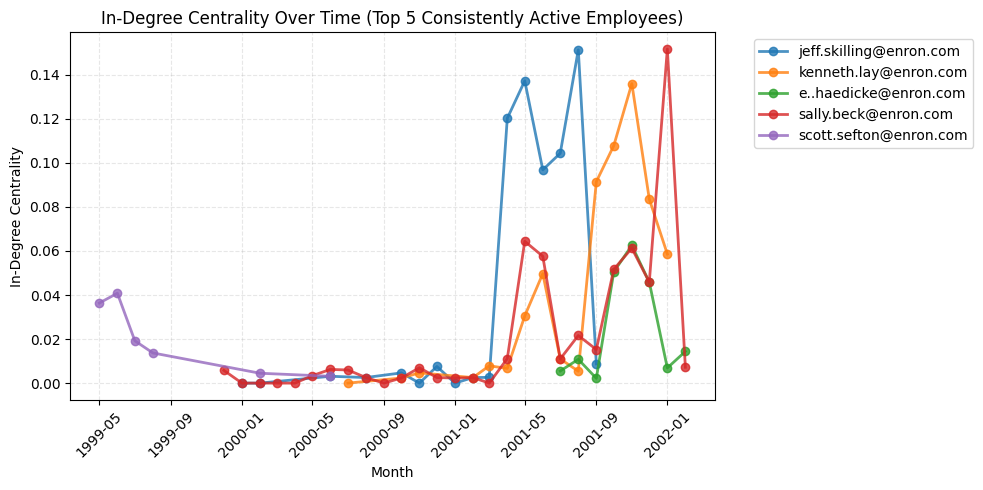

In [78]:
# Minimum number of months a person must appear in to qualify (tune as needed)
min_months = 6  # e.g. appear in 8+ distinct months

# Count how many months each person is active in
activity_counts = (
    metrics_df.groupby("Node")["Month"]
    .nunique()
    .sort_values(ascending=False)
)

# Keep only nodes active in at least N months
active_nodes = activity_counts[activity_counts >= min_months].index

# From those, pick top 5 by average In-Degree
top_nodes_in = (
    metrics_df[metrics_df["Node"].isin(active_nodes)]
    .groupby("Node")["InDegree"]
    .mean()
    .nlargest(5)
    .index
)

#I can alter this graph easily to see the different node embeddings overtime.
plt.figure(figsize=(10, 5))
for node in top_nodes_in:
    subset = metrics_df[metrics_df["Node"] == node].sort_values("Month")
    plt.plot(subset["Month"], subset["InDegree"], label=node, marker="o", linewidth=2, alpha=0.8)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("In-Degree Centrality Over Time (Top 5 Consistently Active Employees)")
plt.xlabel("Month")
plt.ylabel("In-Degree Centrality")
plt.grid(True, linestyle="--", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
#Using temporal GCN, first I have to convert it from a networkX to a torch graph

all_nodes = sorted({n for G in nx_graphs.values() for n in G.nodes()})
node_to_idx = {n: i for i, n in enumerate(all_nodes)}

print(f"Total unique internal nodes: {len(all_nodes)}")

edge_indices, edge_weights, features, targets = [], [], [], []

months_sorted = sorted(nx_graphs.keys())

for month in months_sorted:
    G_t = nx_graphs[month]

    # Build adjacency, but this time do it by month
    data_t = from_networkx(G_t)

    # Node features
    in_deg = nx.in_degree_centrality(G_t)
    out_deg = nx.out_degree_centrality(G_t)
    deg_cent = nx.degree_centrality(G_t)
    clo_cent = nx.closeness_centrality(G_t)
    bet_cent = nx.betweenness_centrality(G_t)
    
    # --- Community detection (for modularity/conductance) ---
    partition = community_louvain.best_partition(G_t.to_undirected())
    modularity_score = community_louvain.modularity(partition, G_t.to_undirected())

    # Compute conductance per node’s community
    conductance = {}
    for comm_id in set(partition.values()):
        members = [n for n, c in partition.items() if c == comm_id]
        subG = G_t.subgraph(members)
        if len(subG) > 1:
            
            # Convert to undirected safely (cut_size requires undirected graph)
            G_u = G_t.to_undirected()

            # Handle edge-less or disconnected cases gracefully
            if len(G_u.edges()) == 0:
                conductance_val = 0
            else:
                try:
                    cut_size = nx.cut_size(G_u, members)
                    vol = sum(dict(G_u.degree(members)).values())
                    conductance_val = (cut_size / vol) if vol > 0 else 0
                except Exception as e:
                    print(f"Conductance error in month {month} community {comm_id}: {e}")
                    conductance_val = 0

        else:
            conductance_val = 0
        for node in members:
            conductance[node] = conductance_val


    #Essentially whats happening here is we are using the getters to pull all the features we calculated in the previous section before the
    #graph to put them into a torch (type! note how its torch.zeros) matrix x_t, as it needs to be of this format to operate on using the Temporal GCN.
    x_t = torch.zeros((len(all_nodes), 5))
    for node in G_t.nodes():
        i = node_to_idx[node]
        x_t[i, 0] = in_deg.get(node, 0)
        x_t[i, 1] = out_deg.get(node, 0)
        x_t[i, 2] = deg_cent.get(node, 0)
        x_t[i, 3] = clo_cent.get(node, 0)
        x_t[i, 4] = bet_cent.get(node, 0)
        #x_t[i, 5] = conductance.get(node, 0)
        #x_t[i, 6] = modularity_score
        #Note for modularity, it is the same for all nodes in a month, only changes by subset.

    edge_indices.append(data_t.edge_index)
    edge_weights.append(data_t.edge_attr)
    features.append(x_t)


###Building temporal dataset for Torch
    dataset = DynamicGraphTemporalSignal(
    edge_indices=edge_indices[:-1],
    edge_weights=edge_weights[:-1],
    features=features[:-1],
    targets=features[1:]
)

print(f"Total snapshots aka months in this case: {len(dataset.features)}")


Total unique internal nodes: 3259
Total snapshots aka months in this case: 37


In [150]:
#Build testing set
all_nodes_test = sorted({n for G in nx_graphs_test.values() for n in G.nodes()})
node_to_idx_test = {n: i for i, n in enumerate(all_nodes_test)}

print(f"Total unique internal nodes: {len(all_nodes_test)}")

edge_indices_test, edge_weights_test, features_test, targets_test = [], [], [], []

months_sorted_test = sorted(nx_graphs_test.keys())

for month in months_sorted_test:
    G_t = nx_graphs_test[month]

    # Build adjacency, but this time do it by month
    data_t = from_networkx(G_t)

    # Node features
    in_deg = nx.in_degree_centrality(G_t)
    out_deg = nx.out_degree_centrality(G_t)
    deg_cent = nx.degree_centrality(G_t)
    clo_cent = nx.closeness_centrality(G_t)
    bet_cent = nx.betweenness_centrality(G_t)

    #Essentially whats happening here is we are using the getters to pull all the features we calculated in the previous section before the
    #graph to put them into a torch (type! note how its torch.zeros) matrix x_t, as it needs to be of this format to operate on using the Temporal GCN.
    x_t = torch.zeros((len(all_nodes_test), 5))
    for node in G_t.nodes():
        i = node_to_idx_test[node]
        x_t[i, 0] = in_deg.get(node, 0)
        x_t[i, 1] = out_deg.get(node, 0)
        x_t[i, 2] = deg_cent.get(node, 0)
        x_t[i, 3] = clo_cent.get(node, 0)
        x_t[i, 4] = bet_cent.get(node, 0)

    edge_indices_test.append(data_t.edge_index)
    edge_weights_test.append(data_t.edge_attr)
    features_test.append(x_t)


###Building temporal dataset for Torch
    dataset_test = DynamicGraphTemporalSignal(
    edge_indices=edge_indices_test[:-1],
    edge_weights=edge_weights_test[:-1],
    features=features_test[:-1],
    targets=features_test[1:]
)

print(f"Total snapshots aka months in this case: {len(dataset_test.features)}")

Total unique internal nodes: 2146
Total snapshots aka months in this case: 34


In [80]:
#Declaring the Temporal GCN

class TGCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.tgcn = TGCN(in_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, in_channels)

    def forward(self, x, edge_index, edge_weight):
        h = self.tgcn(x, edge_index, edge_weight)
        h = F.relu(h)
        return self.linear(h)

In [81]:
#Training

model = TGCNModel(in_channels=5, hidden_channels=32)  # two features: in/out degree
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(15):
    total_loss = 0.0
    for t in range(len(dataset.features)):
        optimizer.zero_grad()
        y_hat = model(dataset.features[t],
                      dataset.edge_indices[t],
                      dataset.edge_weights[t])
        loss = loss_fn(y_hat, dataset.targets[t])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} | Loss: {total_loss:.6f}")

Epoch 00 | Loss: 0.044861
Epoch 01 | Loss: 0.001771
Epoch 02 | Loss: 0.001512
Epoch 03 | Loss: 0.001451
Epoch 04 | Loss: 0.001431
Epoch 05 | Loss: 0.001415
Epoch 06 | Loss: 0.001409
Epoch 07 | Loss: 0.001402
Epoch 08 | Loss: 0.001410
Epoch 09 | Loss: 0.001404
Epoch 10 | Loss: 0.001409
Epoch 11 | Loss: 0.001412
Epoch 12 | Loss: 0.001406
Epoch 13 | Loss: 0.001405
Epoch 14 | Loss: 0.001406


In [155]:
# take the last month's graph as a snapshot of "influence"
G_last = nx_graphs[sorted(nx_graphs.keys())[-1]]
deg_cent = nx.degree_centrality(G_last)

# Create label tensor: 1 = important, 0 = non-important
labels_init = torch.zeros(len(all_nodes), dtype=torch.long)

# top 20 % most central are 'important'
#We are using this as a sort of lightly supervised role, as there are no labels to learn, so providing some to learn off of.
threshold = np.quantile(list(deg_cent.values()), 0.6)
for node, val in deg_cent.items():
    if node in node_to_idx and val >= threshold:
        labels_init[node_to_idx[node]] = 1

In [156]:
# self-supervised temporal prediction
for epoch in range(15):
    total_loss = 0
    for t in range(len(dataset.features)):
        optimizer.zero_grad()
        y_hat = model(dataset.features[t],
                      dataset.edge_indices[t],
                      dataset.edge_weights[t])
        loss = loss_fn(y_hat, dataset.targets[t])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} | Loss {total_loss:.4f}")

Epoch 00 | Loss 0.0013
Epoch 01 | Loss 0.0013
Epoch 02 | Loss 0.0013
Epoch 03 | Loss 0.0013
Epoch 04 | Loss 0.0013
Epoch 05 | Loss 0.0013
Epoch 06 | Loss 0.0013
Epoch 07 | Loss 0.0013
Epoch 08 | Loss 0.0013
Epoch 09 | Loss 0.0014
Epoch 10 | Loss 0.0014
Epoch 11 | Loss 0.0014
Epoch 12 | Loss 0.0013
Epoch 13 | Loss 0.0014
Epoch 14 | Loss 0.0014


In [157]:
with torch.no_grad():
    x_last = dataset.features[-1]
    e_last = dataset.edge_indices[-1]
    w_last = dataset.edge_weights[-1]
    embeddings = model.tgcn(x_last, e_last, w_last)   # [num_nodes, hidden_dim]


In [87]:
#Unrelated to above, this is for testing the transition matrix against certain emails.

print(len(P))

###Testing

start_person = "kenneth.lay@enron.com"
v = np.zeros(len(P))
v[P.index.get_loc(start_person)] = 1.0  # initial probability mass

# Perform diffusion over k steps
for _ in range(5):
    v = v @ P.values  # Markov transitions

# Convert to readable ranking
result = pd.Series(v, index=P.index).sort_values(ascending=False)
print(result.head(10))

result.reset_index().rename(columns={"index": "Person", 0: "Probability"}).to_csv(f"markov_diffusion_results_for_{start_person}.csv", index=False)

6598
john.lavorato@enron.com     0.013529
sally.beck@enron.com        0.012957
e..haedicke@enron.com       0.011215
kenneth.lay@enron.com       0.010037
k..allen@enron.com          0.009584
greg.whalley@enron.com      0.008424
jeff.dasovich@enron.com     0.006276
louise.kitchen@enron.com    0.006128
jeff.skilling@enron.com     0.004560
tim.belden@enron.com        0.003798
dtype: float64
